In [15]:
import sys
import os
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import ast
from tensorflow.keras.utils import load_img

In [16]:
# Parameters
current_directory = os.getcwd()

# Name of the model to be evaluated
model_name = 'EfficientNet2.keras'

# Name of the directory in which files with test results will be saved
evaluation_directory_name = 'eval-test'

# Path to the directory where txt files with results will be saved
evaluation_directory_path = os.path.join(current_directory, evaluation_directory_name)

# Name of the file with the data for each image
eval_file_name = 'evaluation.txt'

# Name of the file with the result data
result_file_name = 'result.txt'

# Path to the folder containing images to be used for testing purposes
images_path = 'C:\\Users\\kacpe\\OneDrive\\Pulpit\\Uczelnia\\semestr5\\MachineLearning\\UTKFace\\Test'

# Parameter defining whether model predicted age accurately - absolute value of difference between labelled age and predicted age
accuracy_param = 7

# Parameter defining whether the accuracy should be checked in relation to the percentage difference or difference between labelled age and predicted age
accuracy_in_percentage = False

# Size of the age group, ex. for age_group_size = 10, the age groups will be [0-9, 10-19, ...] 
age_group_size = 10

# Name of the residuals histogram
residual_histogram_name = 'residuals_histogram.png'

# Name of the RMSE & MAPE plot
rmse_mape_plot_name = 'RMSE_MAPE.png'

In [17]:
# Load the pre-trained model
model_path = os.path.join(current_directory, model_name)
model = load_model(model_path)

# Residuals
residuals = []

In [18]:
# Defining used functions

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory at path: {path}")
    else:
        print("Directory already exists, clearing content...")
        # Clear the contents of the directory
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")

def write_to_text_file(dir_path, file_name, content):
    file_path = os.path.join(dir_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'a') as file:
            file.write(content + '\n')
    else:
        with open(file_path, 'w') as file:
            file.write(content + '\n')

def get_image_features(image):
    img = load_img(image, target_size=(224, 224))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# specific logic for data from: https://www.kaggle.com/datasets/rashikrahmanpritom/age-recognition-dataset
# or other images that contains labelled age in the format: AGE_x_y_z.jpg (age must be in the first index separated by '_' sign)
def eval_image(image_file, dir_path, model, eval_dir, accuracy_param):
    img = get_image_features(os.path.join(dir_path, image_file))

    predictions = model.predict(img)
    age = round(predictions[0][0])

    splitted_text = image_file.split('_')
    labelled_age = int(splitted_text[0])
    difference = abs(labelled_age - age)
    percent_difference = abs(int(difference)) / labelled_age * 100
    is_accurate = round(percent_difference) <= accuracy_param if accuracy_in_percentage else round(difference) <= accuracy_param

    eval_file_name = 'evaluation.txt'
    obj = {
        'Model': age,
        'Label': labelled_age,
        'Difference': difference,
        'PercentageDifference': round(percent_difference),
        'Accurate': is_accurate
    }
    labeled_age = obj['Label']
    predicted_age = obj['Model']
    residuals.append(labeled_age - predicted_age)
    write_to_text_file(eval_dir, eval_file_name, str(obj))

def test_images(directory_path, model, eval_dir, accuracy_param):
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print(f"The specified path '{directory_path}' is not a valid directory.")
        return
    
    files = os.listdir(directory_path)
    
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No image files found in '{directory_path}'.")
        return
    
    for image_file in image_files:
        try:
            eval_image(image_file, directory_path, model, eval_dir, accuracy_param)
        except Exception as e:
            print(f"Error processing {image_file}. Reason: {e}")

def read_residuals(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    results = [ast.literal_eval(line.strip()) for line in lines]
    # Calculate residuals and append to the list
    residuals = []
    for result in results:
        labeled_age = result['Label']
        predicted_age = result['Model']
        residuals.append(labeled_age - predicted_age)
    return residuals

In [19]:
def plot_residual_histogram(residuals, save_path=None):
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residuals Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Count')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def analyze_and_visualize_data(eval_dir, file_path, residuals):
    data_file = os.path.join(eval_dir, file_path)
    if not os.path.exists(data_file):
        print(f'There is no such a file at the path: {data_file}')
        print('Run test_images in order to evaluate the dataset')
        return
    
    with open(data_file, 'r') as file:
        lines = file.readlines()

    data_str = ''.join(lines).replace('\n', ',')

    data_list = eval('[' + data_str + ']')

    df = pd.DataFrame(data_list)

    # Calculate RMSE and MAPE for all data in the dataset
    rmse_all = np.sqrt(mean_squared_error(df['Label'], df['Model']))
    mape_all = np.mean(np.abs((df['Model'] - df['Label']) / df['Label'])) * 100

    print("RMSE for all data:", rmse_all)
    print("MAPE for all data:", mape_all)

    age_ranges = list(range(0, 111, age_group_size))
    age_labels = [f"{start}-{start+age_group_size-1}" for start in age_ranges[:-1]]

    df['AgeGroup'] = pd.cut(df['Label'], bins=age_ranges, labels=age_labels, right=False)

    rmse_groups = []
    mape_groups = []

    for age_group in age_labels:
        group = df[df['AgeGroup'] == age_group]

        if group.empty:
            rmse_groups.append(0)
            mape_groups.append(0)
            continue

        rmse_group = np.sqrt(mean_squared_error(group['Label'], group['Model']))
        mape_group = np.mean(np.abs((group['Model'] - group['Label']) / group['Label'])) * 100
        rmse_groups.append(rmse_group)
        mape_groups.append(mape_group)
        print(f"\nRMSE for age group {age_group}:", rmse_group)
        print(f"MAPE for age group {age_group}:", mape_group)

    count_per_age_group = df['AgeGroup'].value_counts().sort_index()

    correct_predictions = df[df['Accurate'] == True].shape[0]
    total_predictions = df.shape[0]
    accuracy = correct_predictions / total_predictions * 100

    print("\nAccuracy:", accuracy, "%")

    results_dict = {
        'RMSE_all': rmse_all,
        'MAPE_all': mape_all,
        'RMSE_groups': rmse_groups,
        'MAPE_groups': mape_groups,
        'Accuracy': accuracy
    }

    result_file_path = os.path.join(eval_dir, result_file_name)
    with open(result_file_path, 'w') as results_file:
        results_file.write(str(results_dict))

    labels = [str(age_group) for age_group in age_labels]

    # Plot and save the residuals histogram
    if not residuals:
        residuals_file_path = os.path.join(eval_dir, eval_file_name)
        if not os.path.exists(residuals_file_path):
            print(f"Error with file at path: {residuals_file_path}")
            print("There is no file containing data for each image. Run test_images")
            return
        
        residuals = read_residuals(residuals_file_path)
    histogram_save_path = os.path.join(eval_dir, residual_histogram_name)
    if not os.path.exists(eval_dir):
        print('Path to save the RMSE & MAPE plot is not proper')
        return
    plot_residual_histogram(residuals, save_path=histogram_save_path)

    plt.figure(figsize=(16, 6))

    # RMSE plot for age groups
    plt.subplot(2, 2, 1)
    plt.bar(labels, rmse_groups, color='blue')
    plt.title('RMSE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('RMSE')

    # MAPE plot for age groups
    plt.subplot(2, 2, 2)
    plt.bar(labels, mape_groups, color='orange')
    plt.title('MAPE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('MAPE')

    # Number of people in each age group plot
    plt.subplot(2, 2, 3)
    plt.bar(count_per_age_group.index, count_per_age_group.values, color='gray')
    plt.title('Number of Observations in Each Age Group')
    plt.xlabel('Age Groups')
    plt.ylabel('Count')

    # Accuracy pie plot
    plt.subplot(2, 2, 4)
    plt.pie([correct_predictions, total_predictions - correct_predictions], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title(f'Accuracy of Predictions for param: {accuracy_param}')

    plt.tight_layout()

    plot_image_path = os.path.join(eval_dir, rmse_mape_plot_name)
    if not os.path.exists(eval_dir):
        print('Path to save the RMSE & MAPE plot is not proper')
        return
    plt.savefig(plot_image_path)

    plt.show()

In [20]:

# Create directory or remove its content to save data
create_directory(evaluation_directory_path)
# Evaluate test images using provided model 
test_images(images_path, model, evaluation_directory_path, accuracy_param)

Directory already exists, clearing content...
1/1 [==============================] - 0s 404ms/step


RMSE for all data: 24.257014737555
MAPE for all data: 285.0952256772038

RMSE for age group 0-9: 34.69262595571054
MAPE for age group 0-9: 1934.5441565798449

RMSE for age group 10-19: 23.182802883358256
MAPE for age group 10-19: 163.19997824482107

RMSE for age group 20-29: 12.803783230817784
MAPE for age group 20-29: 50.90046288217486

RMSE for age group 30-39: 4.9173103423467035
MAPE for age group 30-39: 12.995342525834246

RMSE for age group 40-49: 6.517378635044439
MAPE for age group 40-49: 12.834116391671701

RMSE for age group 50-59: 16.335215723316075
MAPE for age group 50-59: 29.582832778745367

RMSE for age group 60-69: 25.67816869130148
MAPE for age group 60-69: 40.06124028040884

RMSE for age group 70-79: 35.74148881885736
MAPE for age group 70-79: 48.32990340259041

RMSE for age group 80-89: 45.84251889307064
MAPE for age group 80-89: 54.56988559328584

RMSE for age group 90-99: 53.73051743596936
MAPE for age group 90-99: 58.50792013943167

RMSE for age group 100-109: 63.5

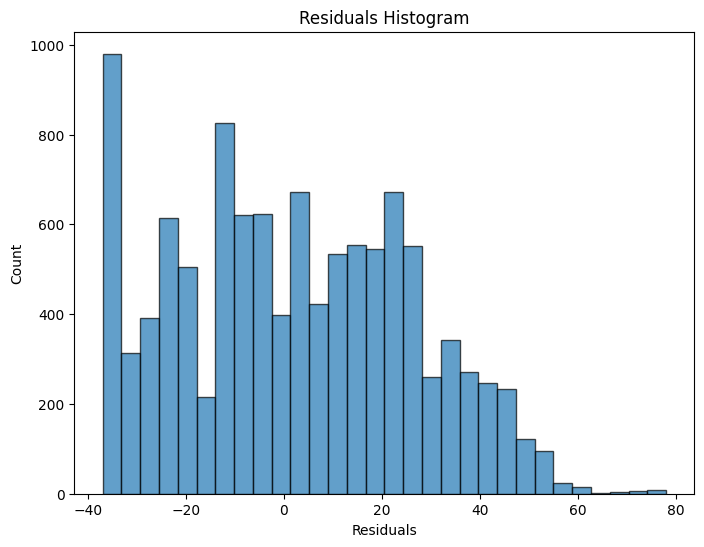

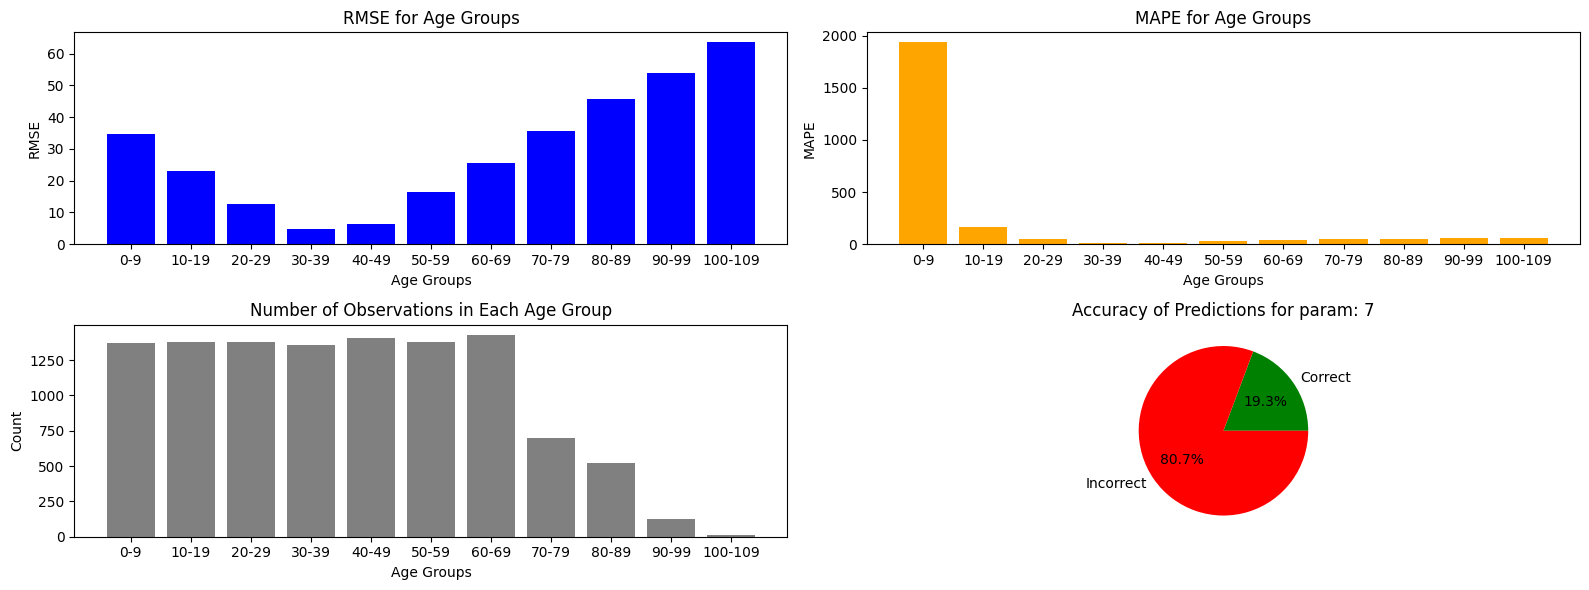

In [21]:
# Analyze and visualize data from the file located at evaluation_directory_path/eval_file_name
analyze_and_visualize_data(evaluation_directory_path, eval_file_name, residuals)